In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
import brewer2mpl
import dateutil
from random import shuffle, randint
import json

%matplotlib inline

In [106]:
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer    
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.grid_search import GridSearchCV

In [107]:
data = pd.read_csv('../data/run/warszawa/data.csv')
data = data.fillna(-1)

#1 Understand data

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31172 entries, 0 to 31171
Data columns (total 39 columns):
market            31172 non-null float64
area              31172 non-null float64
price             31172 non-null int64
floor             31172 non-null object
num_room          31172 non-null float64
num_bedroom       31172 non-null float64
num_bathroom      31172 non-null float64
kitchen           31172 non-null float64
basement          31172 non-null float64
garage            31172 non-null float64
voivodeship       31172 non-null object
powiat            31172 non-null object
gmina             31172 non-null object
place             31172 non-null object
loudness          31172 non-null float64
district          31172 non-null object
street            31172 non-null object
furnished         31172 non-null float64
state_building    31172 non-null float64
type_building     31172 non-null float64
year              31172 non-null float64
source_ad         31172 non-null float6

In [109]:
data.describe()

,market,area,price,num_room,num_bedroom,num_bathroom,kitchen,basement,garage,loudness,...,balcony,elevator,terrace,making,num_levels,type_ownership,land_register,busy_street,technique,surroundings
count,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,...,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172
mean,0.429296,66.852206,575647.763442,2.671436,-0.761773,-0.399076,-0.062267,-0.555819,-0.998717,0.058193,...,-0.118311,-0.460413,-0.913769,1.355640,-0.083569,0.361093,-0.942480,-0.997337,-0.612633,-1
std,1.481844,39.872816,426376.082427,1.030958,0.828709,1.009968,1.229133,0.831316,0.035799,1.235826,...,0.992992,0.887719,0.406241,2.289604,1.038190,1.642307,0.333835,0.061208,0.909627,0
min,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1
25%,-1.000000,47.000000,349000.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1
50%,-1.000000,59.900000,455000.000000,3.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1
75%,2.000000,79.660000,654000.000000,3.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,1.000000,1.000000,2.000000,-1.000000,-1.000000,-1.000000,-1
max,2.000000,4000.000000,9932000.000000,22.000000,20.000000,3.000000,2.000000,1.000000,0.000000,4.000000,...,1.000000,1.000000,1.000000,12.000000,2.000000,5.000000,1.000000,1.000000,5.000000,-1


## 1.1 Base features

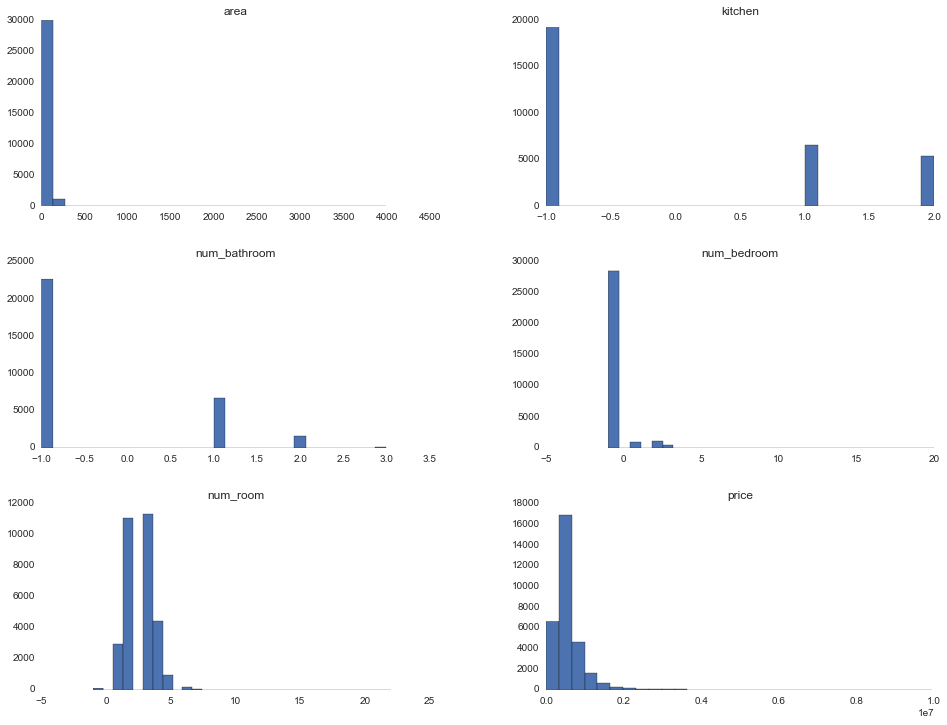

In [110]:
hist_columns = ['area', 'price', 'num_room', 'num_bedroom', 'num_bathroom', 'kitchen']
data[ hist_columns ].hist(figsize=(16,12),bins=30)
plt.show()

## 1.2 Area

In [111]:
def summary(values, percentiles=[1, 5, 95, 99]):
    for percnetile in percentiles:
        print '{0}th -> {1}'.format(percnetile, np.percentile(values, percnetile) )

In [112]:
summary(data.area.values)

1th -> 24.0071
5th -> 31.0
95th -> 125.25
99th -> 172.2


In [113]:
data['area_log'] = data.area.map(lambda x: np.log2(x))
summary(data.area_log.values)

1th -> 4.58538920911
5th -> 4.95419631039
95th -> 6.9686667932
99th -> 7.42794133251


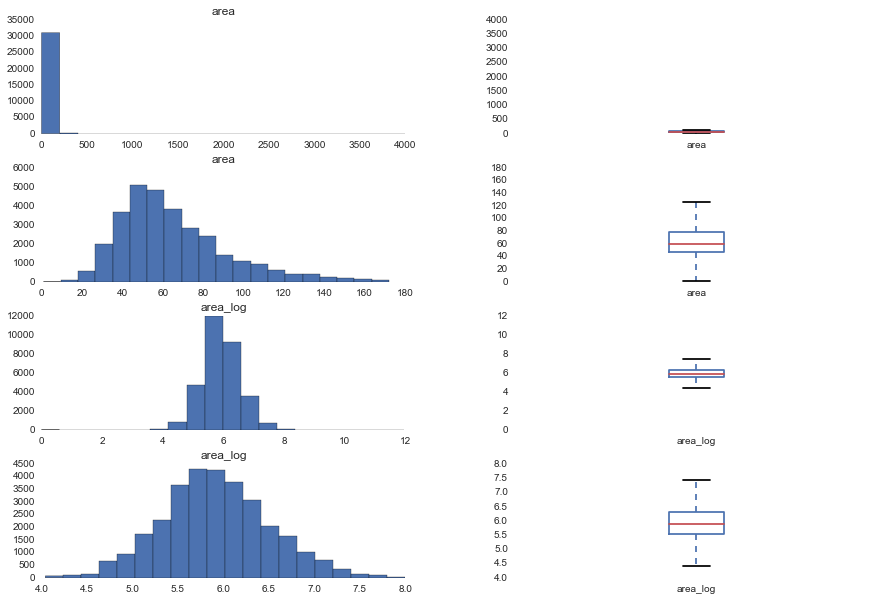

In [114]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=20, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(data, 'area', ax1, ax2)
sub_plot(data[ data.area < 172 ], 'area', ax3, ax4)
sub_plot(data, 'area_log', ax5, ax6)
sub_plot(data[ (data.area_log > 4) & (data.area_log < 8)], 'area_log', ax7, ax8)

**area_log** without outliers looks like **normal distribution**, so removed those outliers.

In [115]:
data = data[ (data.area_log > 4) & (data.area_log < 8)]

##1.3 Price

In [116]:
summary(data.price.values, range(95, 100, 1))

95th -> 1250000.0
96th -> 1350000.0
97th -> 1499000.0
98th -> 1700000.0
99th -> 2200000.0


In [117]:
data['price_log'] = data.price.map(lambda x: np.log2(x))
summary(data['price_log'].values)

1th -> 17.5522187854
5th -> 17.9005948197
95th -> 20.2534966642
99th -> 21.0690720931


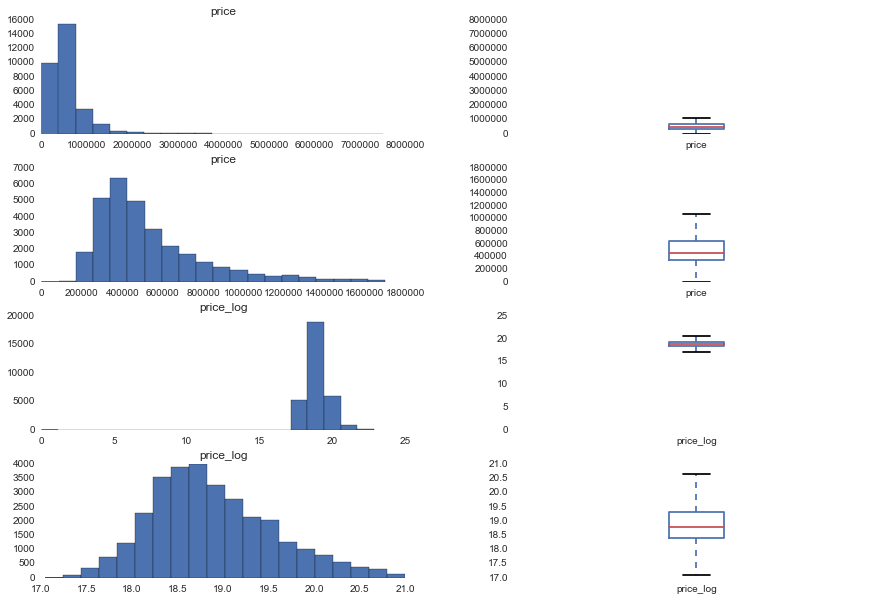

In [118]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(data, 'price', ax1, ax2)
sub_plot(data[ data.price < 1700000 ], 'price', ax3, ax4)
sub_plot(data, 'price_log', ax5, ax6)
sub_plot(data[ (data.price_log > 17) & (data.price_log < 21)], 'price_log', ax7, ax8)

Removed outliers based by **price**

In [119]:
data = data[ (data.price_log > 17) & (data.price_log < 21)]

# 2. Prepare Data
1. Correlation matrix
2. Importance features
3. Feature engineering
4. Feature selection

## 2.1 Correlation matrix

**Let's to see correlation matrix**

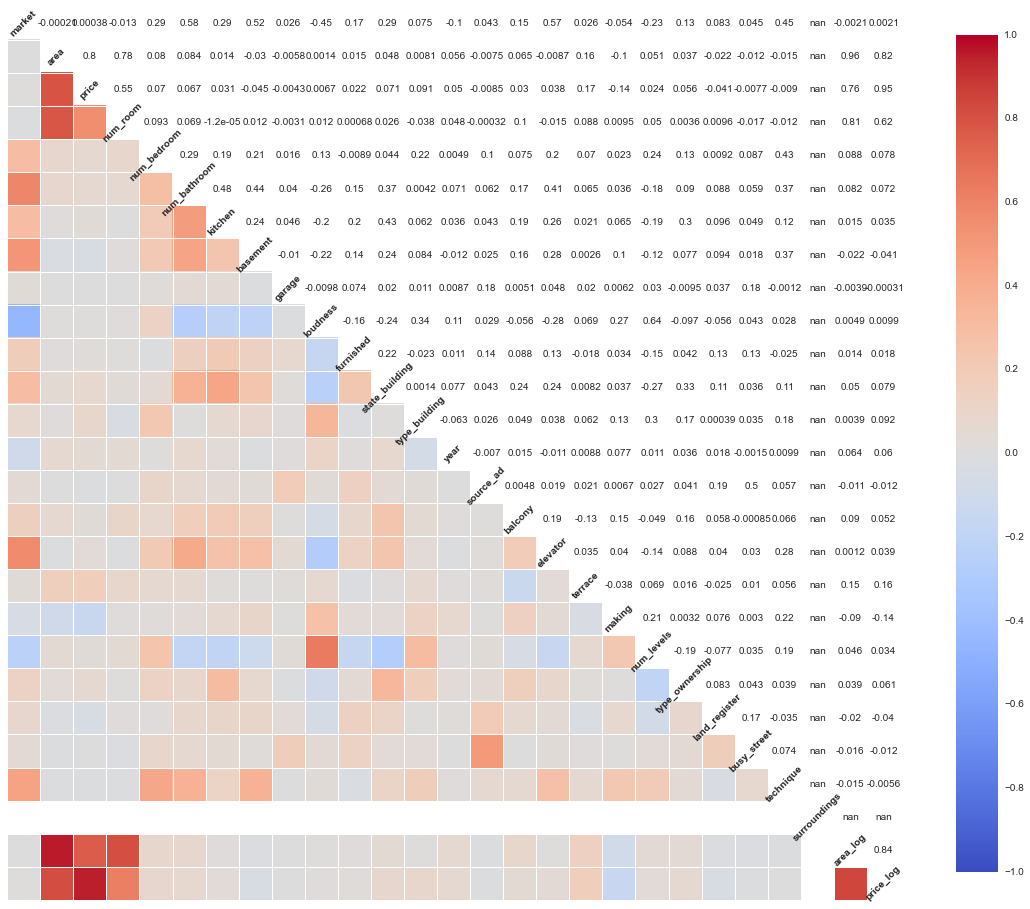

In [120]:
f, ax = plt.subplots(figsize=(20,20))
sns.corrplot(data, sig_stars=False, ax=ax)

Axes(0.125,0.125;0.775x0.775)


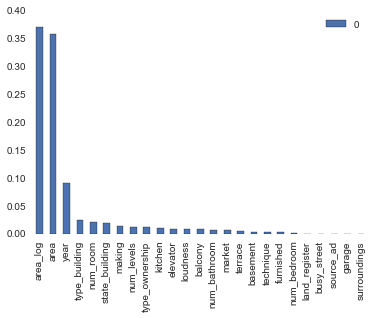

In [121]:
def select_features(data):
    columns = data.loc[ :, data.dtypes != np.object].columns.values    
    return [feat for feat in columns if 'price' not in feat]

def get_X_y(data, cols=None):
    if not cols:
        cols = select_features(data)
        
    X = data[cols].values
    y = data['price'].values
    
    return X,y

def draw_importance_features(data, model=RandomForestRegressor(), limit=25):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    return feats.sort([0], ascending=False) [:limit].plot(kind='bar')


print draw_importance_features(data)

Let's try add new feature - price by meters and log of this value

In [122]:
data.loc[ : , 'price_m2'] = data.apply(lambda x: x['price'] / float(x['area']), axis=1)
summary(data['price_m2'].values)

1th -> 4760.0
5th -> 5593.22033898
95th -> 12766.1058882
99th -> 16897.8217352


In [123]:
data.loc[ : , 'price_m2_log'] = data['price'].map(lambda x: np.log2(x))
summary(data['price_m2_log'].values)

1th -> 17.5656971268
5th -> 17.8985156214
95th -> 20.1825301429
99th -> 20.671416672


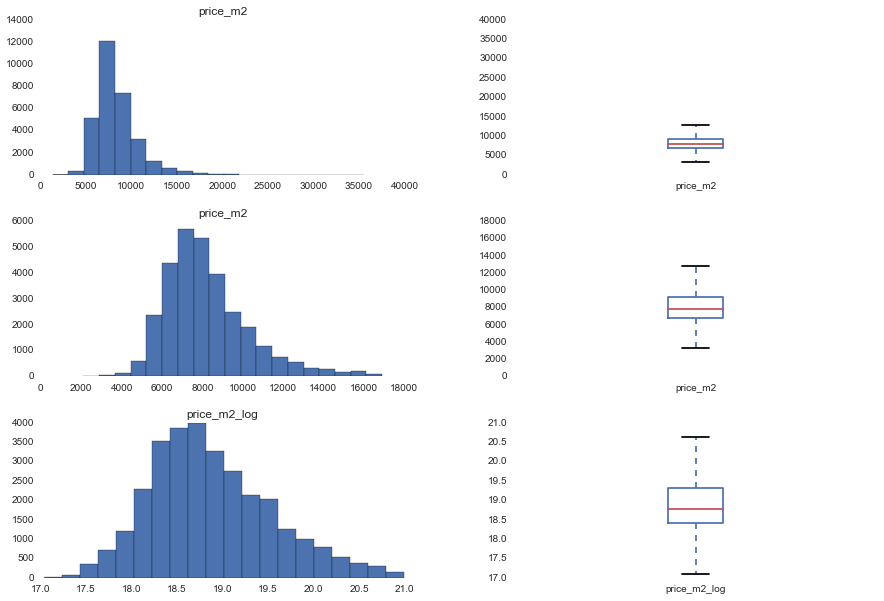

In [124]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(data, 'price_m2', ax1, ax2)
sub_plot(data[ data.price_m2 < 16897 ], 'price_m2', ax3, ax4)
sub_plot(data, 'price_m2_log', ax5, ax6)

Let's removed outliers based on price by m^2

In [125]:
data = data[ data.price_m2 < 16897 ]

Axes(0.125,0.125;0.775x0.775)


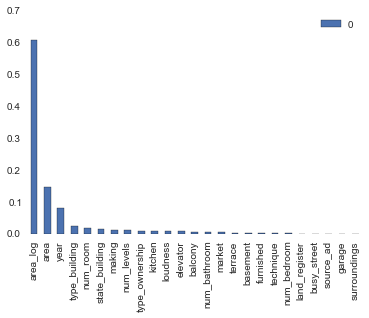

In [126]:
print draw_importance_features(data)

Axes(0.125,0.125;0.775x0.775)


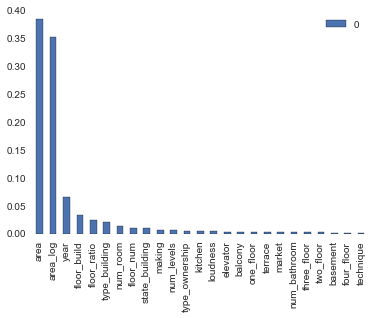

In [127]:
data['floor_num'] = data['floor'].map(lambda x: float(x.split('/')[0]) if isinstance(x, basestring) else -1 )
data['floor_build'] = data['floor'].map(lambda x: float(x.split('/')[1]) if isinstance(x, basestring) else -1)
data['floor_ratio'] = (data['floor_build'] + 1) / (data['floor_num']  + 1)
data['floor_ratio'].fillna(-1, inplace=True)

data['last_floor'] = data['floor_num'] == data['floor_build']
data['zero_floor'] = data['floor_num'] == 0
data['one_floor'] = data['floor_num'] == 1
data['two_floor'] = data['floor_num'] == 2
data['three_floor'] = data['floor_num'] == 3
data['four_floor'] = data['floor_num'] == 4
data['five_floor'] = data['floor_num'] == 5

print draw_importance_features(data)

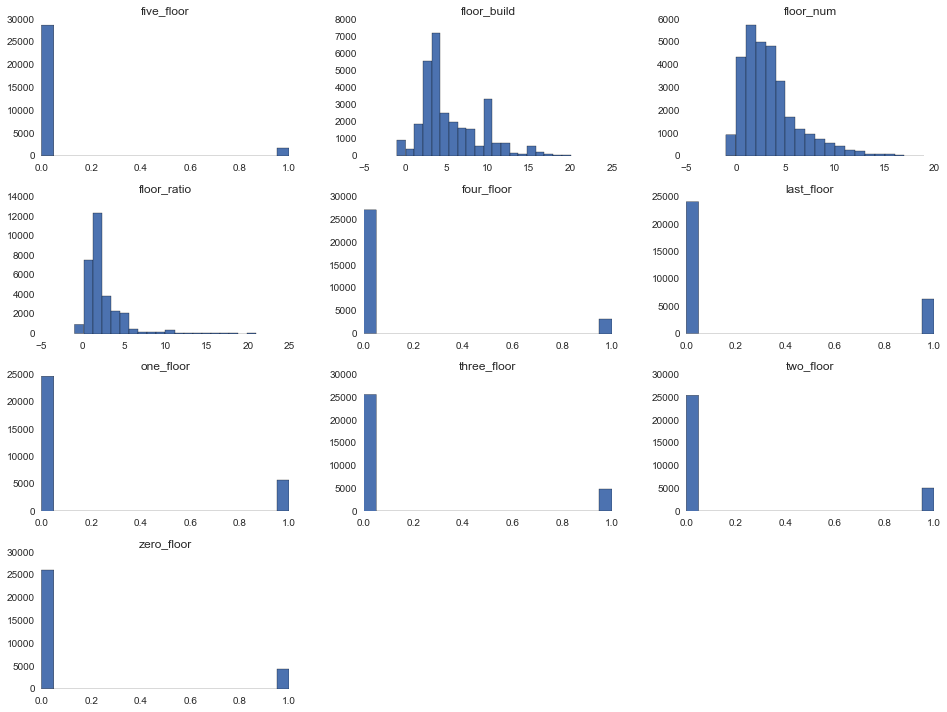

In [128]:
floor_cols = [c for c in data.columns.values if 'floor' in c]
data[ floor_cols ].hist(figsize=(16,12),bins=20)
plt.show()

Axes(0.125,0.125;0.775x0.775)


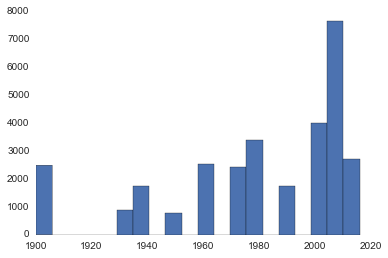

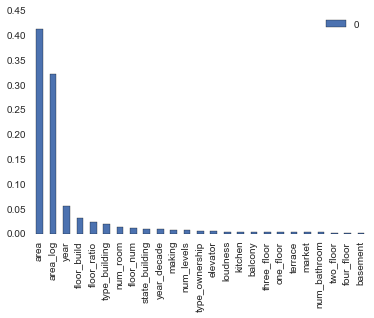

In [129]:
def year_decade(year):
    if year < 1901:
        return 1900
    elif year < 1931:
        return 1930
    elif year < 1941:
        return 1940
    elif year < 1951:
        return 1950
    elif year < 1961:
        return 1960
    elif year < 1971:
        return 1970
    elif year < 1981:
        return 1980
    elif year < 1991:
        return 1990
    elif year < 2001:
        return 2000
    elif year < 2006:
        return 2005
    elif year < 2011:
        return 2010
    elif year < 2012:
        return 2012
    elif year < 2015:
        return 2014
    else:
        return year
    

data['year_decade'] = data['year'].map(year_decade)

data['year_decade'].hist(bins=20)
print draw_importance_features(data)

In [134]:
data['how_old'] = data.year.map(lambda x: -1 if x == -1 else 2015 - x)
summary(data['how_old'].values)

1th -> -1.0
5th -> -1.0
95th -> 80.0
99th -> 103.0


In [174]:
data['how_old_log'] = data['how_old'].map(lambda x: -1 if x < 1 else np.log2(x))

summary(data['how_old_log'].values)

1th -> -1.0
5th -> -1.0
95th -> 6.32192809489
99th -> 6.68650052718


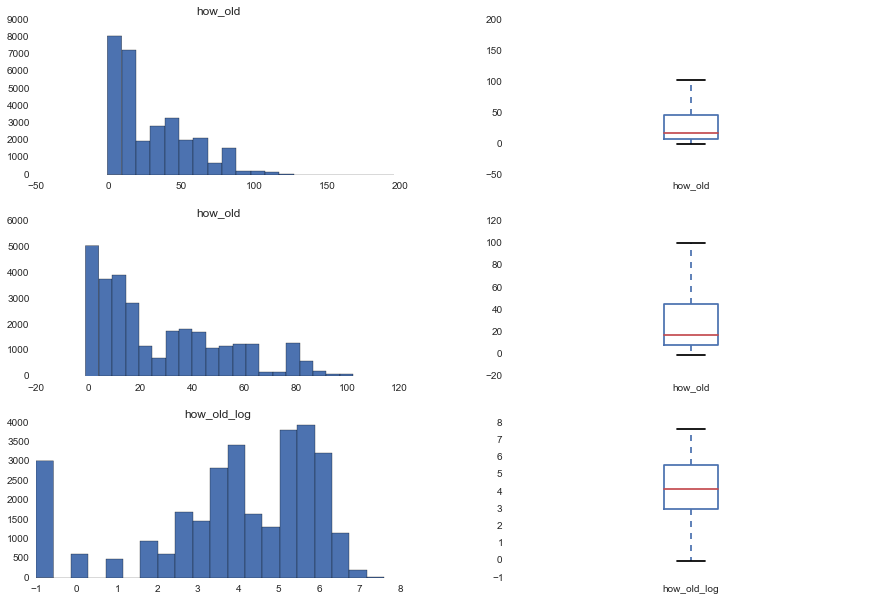

In [175]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(data, 'how_old', ax1, ax2)
sub_plot(data[ data.how_old < 103 ], 'how_old', ax3, ax4)
sub_plot(data[ False == data.how_old.isnull() ], 'how_old_log', ax5, ax6)

Axes(0.125,0.125;0.775x0.775)


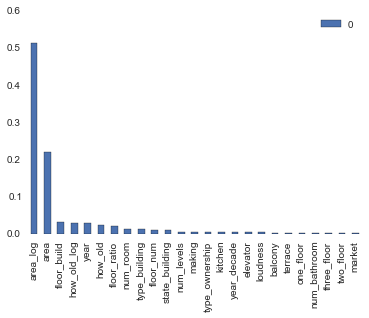

In [176]:
print draw_importance_features(data)

### Normalize districts

,district,count
0,-1,378
1,bemowo,2158
2,białołęka,1805
3,bielany,1737
4,mokotów,4012
5,ochota,1670
6,praga-południe,3423
7,praga-północ,752
8,rembertów,211
9,targówek,1294


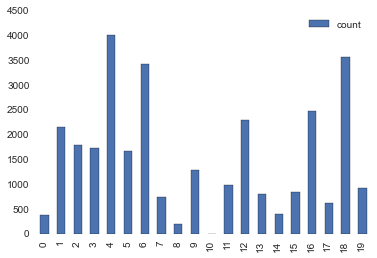

In [181]:
import json

districts = None
with open('../data/info/warszawa/district.json', 'r') as f:
    districts = json.loads(f.read())


subdistrict_to_district = {}
for key in districts.keys():
    for value in districts[key]:
        subdistrict_to_district[value] = key

def norm_district(district):
    if False == isinstance (district, basestring):
        return district

    district = district.decode("utf8")
    if  district in districts:
        return district
    elif district in subdistrict_to_district:
        return subdistrict_to_district[district]
    else:
        return 'unknown'
    
data['district_norm'] = data['district'].map(norm_district)
district = data.groupby('district_norm').count()['market'].reset_index()
district.columns = ['district', 'count']
district.plot(kind='bar')

district

[(0, u'ochota'), (1, -1), (2, u'targ\xf3wek'), (3, u'ursyn\xf3w'), (4, u'weso\u0142a'), (5, u'\u015br\xf3dmie\u015bcie'), (6, u'bielany'), (7, u'wola'), (8, u'ursus'), (9, u'w\u0142ochy'), (10, u'wilan\xf3w'), (11, u'praga-p\xf3\u0142noc'), (12, u'mokot\xf3w'), (13, u'bia\u0142o\u0142\u0119ka'), (14, u'praga-po\u0142udnie'), (15, u'bemowo'), (16, u'\u017coliborz'), (17, u'wawer'), (18, u'rembert\xf3w'), (19, 'unknown')]
Axes(0.125,0.125;0.775x0.775)


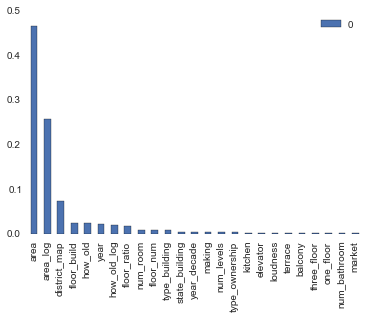

In [182]:
data['district_map'], district_indexes =  pd.factorize(data.district_norm)
print list(enumerate(district_indexes))

print draw_importance_features(data)

## Train/test split

In [183]:
def get_train_test(data, target_column, cols = None):
    data['is_test'] = data['price'].map( lambda x: randint(1, 3) == 3 )
    if cols is None:
        cols = ['area', 'area_log', 'num_room', 'year', 'making']

    train = data[ False == data['is_test'] ]
    test  = data[ True  == data['is_test'] ]

    X_train = train[cols].values
    y_train = train[target_column].values
    X_test  = test[cols].values
    y_test  = test[target_column].values
    
    return X_train, X_test, y_train, y_test


cols = select_features(data)
X_train, X_test, y_train, y_test = get_train_test(data, 'price', cols)
train = data[ False == data.is_test ] 
test  = data[ True == data.is_test ] 

## Quality function - MAPE

In [184]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Single variable model
It's the simple possible (and relatively sensible) model which we can treat like base line.

In [185]:
mean_price = train['price_m2'].mean()
test.loc[ : , 'pred_price_mean'] = test['area'].map(lambda area: area * mean_price)

print 'r2', r2_score(test['price'].values, test['pred_price_mean'].values)
print 'mae', mean_absolute_error(test['price'].values, test['pred_price_mean'].values)
print 'mape', mean_absolute_percentage_error(test['price'].values, test['pred_price_mean'].values)

r2 0.673509454177
mae 110359.198501
mape 19.8481163231


## Two variables model
Based on price and district.

In [213]:
district_prices = train[ ['district_map', 'price_m2'] ].groupby('district_map').agg(np.mean).to_dict()['price_m2']

test.loc[ : , 'pred_price_mean_district'] = test.apply(lambda x: district_prices[ x['district_map'] ] * x['area'], axis=1)

print 'r2', r2_score(test['price'].values, test['pred_price_mean_district'].values)
print 'mae', mean_absolute_error(test['price'].values, test['pred_price_mean_district'].values)
print 'mape', mean_absolute_percentage_error(test['price'].values, test['pred_price_mean_district'].values)

r2 0.784804911694
mae 87353.8205367
mape 15.2836511067


## More advanced models

In [186]:
def models():
    yield ('extra_tree', ExtraTreesRegressor())
    yield ('random_forest', RandomForestRegressor())
    yield ('bagging', BaggingRegressor())
    yield ('gradient_boos', GradientBoostingRegressor())
    yield ('dec_tree', DecisionTreeRegressor())

In [187]:
for name, model in models():
    model.fit(X_train, y_train)
    
    key_pred_model = 'pred_price_{0}'.format(name)
    test.loc[ : , key_pred_model ] = model.predict(X_test)

    print model
    print 'r2', r2_score(test['price'].values, test[key_pred_model].values)
    print 'mae', mean_absolute_error(test['price'].values, test[key_pred_model].values)
    print 'mape', mean_absolute_percentage_error(test['price'].values, test[key_pred_model].values)
    

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
r2 0.83994564693
mae 67647.6979462
mape 11.7862307018
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
r2 0.857266204946
mae 64348.3215542
mape 11.1237746342
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0)
r2 0.853768535652
mae 64773.5859044
mape

## Ensemble models

In [188]:
pred_columns = [ c for c in test.columns.values if 'pred' in c ]
pred_columns = ['pred_price_dec_tree', 'pred_price_extra_tree', 'pred_price_bagging', 'pred_price_random_forest']
test.loc[ : , 'pred_price_ensemble'] = test[pred_columns].apply(np.mean, axis=1)

print 'r2', r2_score(test['price'].values, test['pred_price_ensemble'].values)
print 'mae', mean_absolute_error(test['price'].values, test['pred_price_ensemble'].values)
print 'mape', mean_absolute_percentage_error(test['price'].values, test['pred_price_ensemble'].values)

r2 0.866951687071
mae 60967.9483594
mape 10.5813243505


In [189]:
test[ ['price', 'pred_price_ensemble'] + pred_columns ].head()

,price,pred_price_ensemble,pred_price_dec_tree,pred_price_extra_tree,pred_price_bagging,pred_price_random_forest
2,243000,247572.50,235000,267790.0,258300.0,229200.0
4,319000,331340.00,319000,319000.0,329100.0,358260.0
5,240000,261475.00,265000,263000.0,261400.0,256500.0
6,275000,256987.50,250000,250400.0,260300.0,267250.0
9,180000,192611.95,180000,192292.2,197427.8,200727.8


In [214]:
def get_winner(row):
    pred_columns = [ c for c in test.columns.values if 'pred' in c]
    min_diff = 1e10
    p_col = pred_columns[0]
    
    for p_col in pred_columns:
        
        diff = abs(row['price'] - row[p_col])
        
        if diff < min_diff:
            winner = p_col
            min_diff = diff
            
    return winner


test.loc[ : , 'winner'] = test.apply(get_winner, axis=1)
test.groupby('winner').count()['market'].reset_index().sort('market', ascending=False)

,winner,market
1,pred_price_dec_tree,2279
3,pred_price_extra_tree,1712
7,pred_price_random_forest,1197
0,pred_price_bagging,1179
4,pred_price_gradient_boos,1073
6,pred_price_mean_district,1052
2,pred_price_ensemble,808
5,pred_price_mean,730


## Tuning ML
Let's try do tuning for three models: 
- RandomForestRegressor
- BaggingRegressor
- DecisionTreeRegressor

In [193]:
cols = select_features(data)
X = data[cols].values
y = data['price'].values

In [194]:
model = RandomForestRegressor()
param_model = {'n_estimators': [50, 100, 200], 'min_samples_split': [2, 5, 10]}
grid = GridSearchCV(model, param_grid=param_model, cv=3, scoring='mean_absolute_error', n_jobs=-1)
grid.fit(X,y)

print grid.best_params_, grid.best_score_

{'min_samples_split': 2, 'n_estimators': 200} -63213.4333694
